<a href="https://colab.research.google.com/github/ProjectHarvard/KumbhNet/blob/Phase-1/KumbhNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("✓ GPU is ready!")
else:
    print("✗ GPU not found - check runtime settings")

GPU Available: True
GPU Name: Tesla T4
✓ GPU is ready!


In [3]:
import os

# Create main directory
base_dir = "KumbhNet"
os.makedirs(base_dir, exist_ok=True)

# Create all subdirectories
folders = [
    "data/videos/raw",
    "data/videos/processed",
    "data/models",
    "outputs/detections/frame_by_frame",
    "outputs/analytics",
    "outputs/demo/screenshots",
    "src",
    "scripts",
    "config"
]

for folder in folders:
    os.makedirs(f"{base_dir}/{folder}", exist_ok=True)

print("✓ Project structure created!")
print("\nFolders created:")
for folder in folders:
    print(f"  - {folder}")

✓ Project structure created!

Folders created:
  - data/videos/raw
  - data/videos/processed
  - data/models
  - outputs/detections/frame_by_frame
  - outputs/analytics
  - outputs/demo/screenshots
  - src
  - scripts
  - config


In [4]:
# This takes 2-3 minutes - wait for it to complete

print("Installing packages... (this takes 2-3 minutes)")

# Install ultralytics (includes YOLOv8)
!pip install -q ultralytics

# Install other required packages
!pip install -q opencv-python-headless
!pip install -q matplotlib seaborn
!pip install -q pandas tqdm

# Install yt-dlp for downloading videos
!pip install -q yt-dlp

print("\n✓ All packages installed!")

# Verify installation
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
print("✓ Imports successful!")

Installing packages... (this takes 2-3 minutes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 86.5 MB/s eta 0:00:00

✓ All packages installed!
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✓ Imports successful!


In [5]:
# Change to project directory
%cd KumbhNet

# Download YOLOv8 nano model (smallest, fastest)
print("Downloading YOLOv8 model...")

from ultralytics import YOLO

# This automatically downloads the model (90MB)
model = YOLO('yolov8n.pt')

print("✓ YOLOv8 model downloaded!")
print(f"✓ Model saved to: data/models/yolov8n.pt")

# Test the model on a blank image
import numpy as np
test_image = np.zeros((640, 640, 3), dtype=np.uint8)
results = model(test_image, verbose=False)
print("✓ Model is working!")

/content/KumbhNet
✓ YOLOv8 model downloaded!
✓ Model saved to: data/models/yolov8n.pt
✓ Model is working!


In [6]:
from google.colab import files
import shutil

print("Click 'Choose Files' button below to upload video from your computer")
print("Recommended: Video should be 1-5 minutes long, MP4 format\n")

# This opens file picker
uploaded = files.upload()

# Move uploaded file to correct folder
for filename in uploaded.keys():
    # Get the uploaded file
    source = filename
    destination = f"data/videos/raw/{filename}"

    # Move to raw videos folder
    shutil.move(source, destination)
    print(f"✓ Video uploaded: {filename}")
    print(f"✓ Moved to: {destination}")

print("\n✓ Ready to process!")

Click 'Choose Files' button below to upload video from your computer
Recommended: Video should be 1-5 minutes long, MP4 format



Saving Crowd at kumbh mela at PARAYAGRAJ - Gautam_A_yadav (720p, h264).mp4 to Crowd at kumbh mela at PARAYAGRAJ - Gautam_A_yadav (720p, h264).mp4
✓ Video uploaded: Crowd at kumbh mela at PARAYAGRAJ - Gautam_A_yadav (720p, h264).mp4
✓ Moved to: data/videos/raw/Crowd at kumbh mela at PARAYAGRAJ - Gautam_A_yadav (720p, h264).mp4

✓ Ready to process!


In [7]:
import os
import cv2

# Check what videos we have
video_folder = "data/videos/raw"
videos = [f for f in os.listdir(video_folder) if f.endswith(('.mp4', '.avi', '.mov'))]

print(f"Found {len(videos)} video(s):\n")

for video in videos:
    video_path = os.path.join(video_folder, video)

    # Get video info
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    duration = frame_count / fps

    print(f"📹 {video}")
    print(f"   Resolution: {width}x{height}")
    print(f"   FPS: {fps}")
    print(f"   Duration: {duration:.1f} seconds")
    print(f"   Total frames: {frame_count}\n")

    cap.release()

if len(videos) == 0:
    print("⚠️ No videos found! Please upload or download videos first.")
else:
    print("✓ Videos are ready to process!")

Found 1 video(s):

📹 Crowd at kumbh mela at PARAYAGRAJ - Gautam_A_yadav (720p, h264).mp4
   Resolution: 1280x720
   FPS: 30
   Duration: 78.7 seconds
   Total frames: 2361

✓ Videos are ready to process!


In [8]:
# Configuration settings for detection

config = {
    'model': {
        'name': 'yolov8n.pt',
        'confidence': 0.25,  # How confident the model should be
        'iou': 0.45          # Overlap threshold
    },
    'processing': {
        'frame_skip': 2,      # Process every 2nd frame (faster)
        'resize_width': 1280,
        'resize_height': 720
    },
    'alerts': {
        'low': 20,           # < 20 people = LOW
        'medium': 50,        # 20-50 = MEDIUM
        'high': 100,         # 50-100 = HIGH
        'critical': 150      # > 150 = CRITICAL
    },
    'visualization': {
        'box_color': (0, 255, 0),      # Green boxes
        'box_thickness': 2,
        'text_color': (255, 255, 255),  # White text
        'font_scale': 0.6
    }
}

print("✓ Configuration loaded!")
print("\nAlert Thresholds:")
print(f"  LOW: < {config['alerts']['low']} people")
print(f"  MEDIUM: {config['alerts']['low']}-{config['alerts']['medium']} people")
print(f"  HIGH: {config['alerts']['medium']}-{config['alerts']['high']} people")
print(f"  CRITICAL: > {config['alerts']['critical']} people")

✓ Configuration loaded!

Alert Thresholds:
  LOW: < 20 people
  MEDIUM: 20-50 people
  HIGH: 50-100 people
  CRITICAL: > 150 people


In [9]:
import cv2
import numpy as np
from ultralytics import YOLO
import json
from datetime import datetime

class PersonDetector:
    def __init__(self, model_path='yolov8n.pt', config=None):
        """Initialize the person detector"""
        print("Initializing Person Detector...")

        # Load YOLO model
        self.model = YOLO(model_path)
        self.config = config if config else {}

        print("✓ Detector ready!")

    def detect_frame(self, frame):
        """
        Detect persons in a single frame

        Returns:
            detections: List of detected persons with bounding boxes
            count: Number of persons detected
        """
        # Run YOLO detection
        results = self.model(frame, verbose=False)[0]

        # Filter for 'person' class only (class ID = 0 in COCO)
        detections = []

        for box in results.boxes:
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])

            # Only keep person detections
            if class_id == 0:  # 0 = person in COCO dataset
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()

                detections.append({
                    'bbox': [int(x1), int(y1), int(x2), int(y2)],
                    'confidence': confidence
                })

        return detections, len(detections)

    def get_alert_level(self, count):
        """Determine alert level based on person count"""
        thresholds = self.config.get('alerts', {})

        if count < thresholds.get('low', 20):
            return 'LOW', (0, 255, 0)  # Green
        elif count < thresholds.get('medium', 50):
            return 'MEDIUM', (0, 255, 255)  # Yellow
        elif count < thresholds.get('high', 100):
            return 'HIGH', (0, 165, 255)  # Orange
        else:
            return 'CRITICAL', (0, 0, 255)  # Red

    def annotate_frame(self, frame, detections, count):
        """Draw bounding boxes and info on frame"""
        annotated = frame.copy()
        viz_config = self.config.get('visualization', {})

        # Draw bounding boxes
        for det in detections:
            x1, y1, x2, y2 = det['bbox']
            conf = det['confidence']

            # Draw rectangle
            cv2.rectangle(annotated, (x1, y1), (x2, y2),
                         viz_config.get('box_color', (0, 255, 0)),
                         viz_config.get('box_thickness', 2))

            # Draw confidence score
            label = f"{conf:.2f}"
            cv2.putText(annotated, label, (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Get alert level
        alert_level, alert_color = self.get_alert_level(count)

        # Add overlay with count and alert
        overlay = annotated.copy()
        cv2.rectangle(overlay, (10, 10), (400, 120), (0, 0, 0), -1)
        cv2.addWeighted(overlay, 0.6, annotated, 0.4, 0, annotated)

        # Add text information
        cv2.putText(annotated, f"SANRAKSHAK - Person Detection",
                   (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        cv2.putText(annotated, f"Person Count: {count}",
                   (20, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

        cv2.putText(annotated, f"Alert Level: {alert_level}",
                   (20, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, alert_color, 2)

        return annotated, alert_level

print("✓ PersonDetector class created!")

✓ PersonDetector class created!


In [10]:
from tqdm import tqdm
import pandas as pd

class VideoProcessor:
    def __init__(self, detector, config=None):
        """Initialize video processor"""
        self.detector = detector
        self.config = config if config else {}

    def process_video(self, input_path, output_path):
        """
        Process entire video with person detection

        Returns:
            statistics: Dictionary with detection statistics
        """
        print(f"\n📹 Processing: {input_path}")

        # Open video
        cap = cv2.VideoCapture(input_path)

        # Get video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"   Resolution: {width}x{height}")
        print(f"   FPS: {fps}")
        print(f"   Total frames: {total_frames}")

        # Setup video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        # Statistics tracking
        frame_stats = []
        alerts_log = []

        frame_skip = self.config.get('processing', {}).get('frame_skip', 2)
        frame_count = 0
        processed_count = 0

        # Process with progress bar
        pbar = tqdm(total=total_frames, desc="  Detecting persons")

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Process every Nth frame
            if frame_count % frame_skip == 0:
                # Detect persons
                detections, count = self.detector.detect_frame(frame)

                # Annotate frame
                annotated, alert_level = self.detector.annotate_frame(
                    frame, detections, count
                )

                # Write annotated frame
                out.write(annotated)

                # Save statistics
                timestamp = frame_count / fps
                frame_stats.append({
                    'frame': frame_count,
                    'timestamp': timestamp,
                    'person_count': count,
                    'alert_level': alert_level
                })

                # Log alerts
                if alert_level in ['HIGH', 'CRITICAL']:
                    alerts_log.append({
                        'timestamp': timestamp,
                        'frame': frame_count,
                        'level': alert_level,
                        'count': count
                    })

                processed_count += 1
            else:
                # Just write original frame
                out.write(frame)

            frame_count += 1
            pbar.update(1)

        pbar.close()
        cap.release()
        out.release()

        print(f"   ✓ Processed {processed_count} frames")
        print(f"   ✓ Output: {output_path}")

        # Calculate summary statistics
        df = pd.DataFrame(frame_stats)

        statistics = {
            'video_name': input_path.split('/')[-1],
            'total_frames': total_frames,
            'processed_frames': processed_count,
            'duration_seconds': total_frames / fps,
            'avg_person_count': df['person_count'].mean(),
            'max_person_count': df['person_count'].max(),
            'min_person_count': df['person_count'].min(),
            'total_alerts': len(alerts_log),
            'frame_data': frame_stats,
            'alerts': alerts_log
        }

        return statistics

print("✓ VideoProcessor class created!")

✓ VideoProcessor class created!


In [11]:
import os
import json

# Initialize detector
detector = PersonDetector('yolov8n.pt', config)
processor = VideoProcessor(detector, config)

# Get all videos
input_dir = "data/videos/raw"
output_dir = "data/videos/processed"
stats_dir = "outputs/detections"

videos = [f for f in os.listdir(input_dir) if f.endswith(('.mp4', '.avi', '.mov'))]

print(f"Found {len(videos)} video(s) to process\n")
print("="*60)

all_statistics = []

for i, video_file in enumerate(videos, 1):
    print(f"\n[{i}/{len(videos)}] Processing: {video_file}")
    print("="*60)

    input_path = os.path.join(input_dir, video_file)
    output_filename = f"detected_{video_file}"
    output_path = os.path.join(output_dir, output_filename)

    try:
        # Process video
        stats = processor.process_video(input_path, output_path)
        all_statistics.append(stats)

        # Save statistics to JSON
        stats_filename = video_file.replace('.mp4', '_stats.json')
        stats_path = os.path.join(stats_dir, stats_filename)

        with open(stats_path, 'w') as f:
            json.dump(stats, f, indent=2)

        print(f"\n   📊 Statistics:")
        print(f"      Average count: {stats['avg_person_count']:.1f} persons")
        print(f"      Peak count: {stats['max_person_count']} persons")
        print(f"      Total alerts: {stats['total_alerts']}")
        print(f"      Stats saved: {stats_path}")

    except Exception as e:
        print(f"   ✗ Error: {e}")
        continue

print("\n" + "="*60)
print("✓ ALL VIDEOS PROCESSED!")
print("="*60)

# Summary
print(f"\nProcessed {len(all_statistics)} videos successfully")
print(f"Output videos: {output_dir}/")
print(f"Statistics: {stats_dir}/")

Initializing Person Detector...
✓ Detector ready!
Found 1 video(s) to process


[1/1] Processing: Crowd at kumbh mela at PARAYAGRAJ - Gautam_A_yadav (720p, h264).mp4

📹 Processing: data/videos/raw/Crowd at kumbh mela at PARAYAGRAJ - Gautam_A_yadav (720p, h264).mp4
   Resolution: 1280x720
   FPS: 30
   Total frames: 2361


  Detecting persons: 100%|█████████▉| 2358/2361 [00:44<00:00, 53.21it/s]


   ✓ Processed 1179 frames
   ✓ Output: data/videos/processed/detected_Crowd at kumbh mela at PARAYAGRAJ - Gautam_A_yadav (720p, h264).mp4

   📊 Statistics:
      Average count: 8.0 persons
      Peak count: 28 persons
      Total alerts: 0
      Stats saved: outputs/detections/Crowd at kumbh mela at PARAYAGRAJ - Gautam_A_yadav (720p, h264)_stats.json

✓ ALL VIDEOS PROCESSED!

Processed 1 videos successfully
Output videos: data/videos/processed/
Statistics: outputs/detections/


Generating analytics...



/tmp/ipython-input-4146789851.py:78: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-4146789851.py:78: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-4146789851.py:78: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-4146789851.py:82: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(output_path, dpi=150, bbox_inches='tight')
/tmp/ipython-input-4146789851.py:82: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(output_path, dpi=150, bbox_inches='tight')
/tmp/ipython-input-4146789851.py:82: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(output_path, dpi=150, bbox_inches='tight')


✓ Analytics saved: outputs/analytics/Crowd at kumbh mela at PARAYAGRAJ - Gautam_A_yadav (720p, h264)_analytics.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


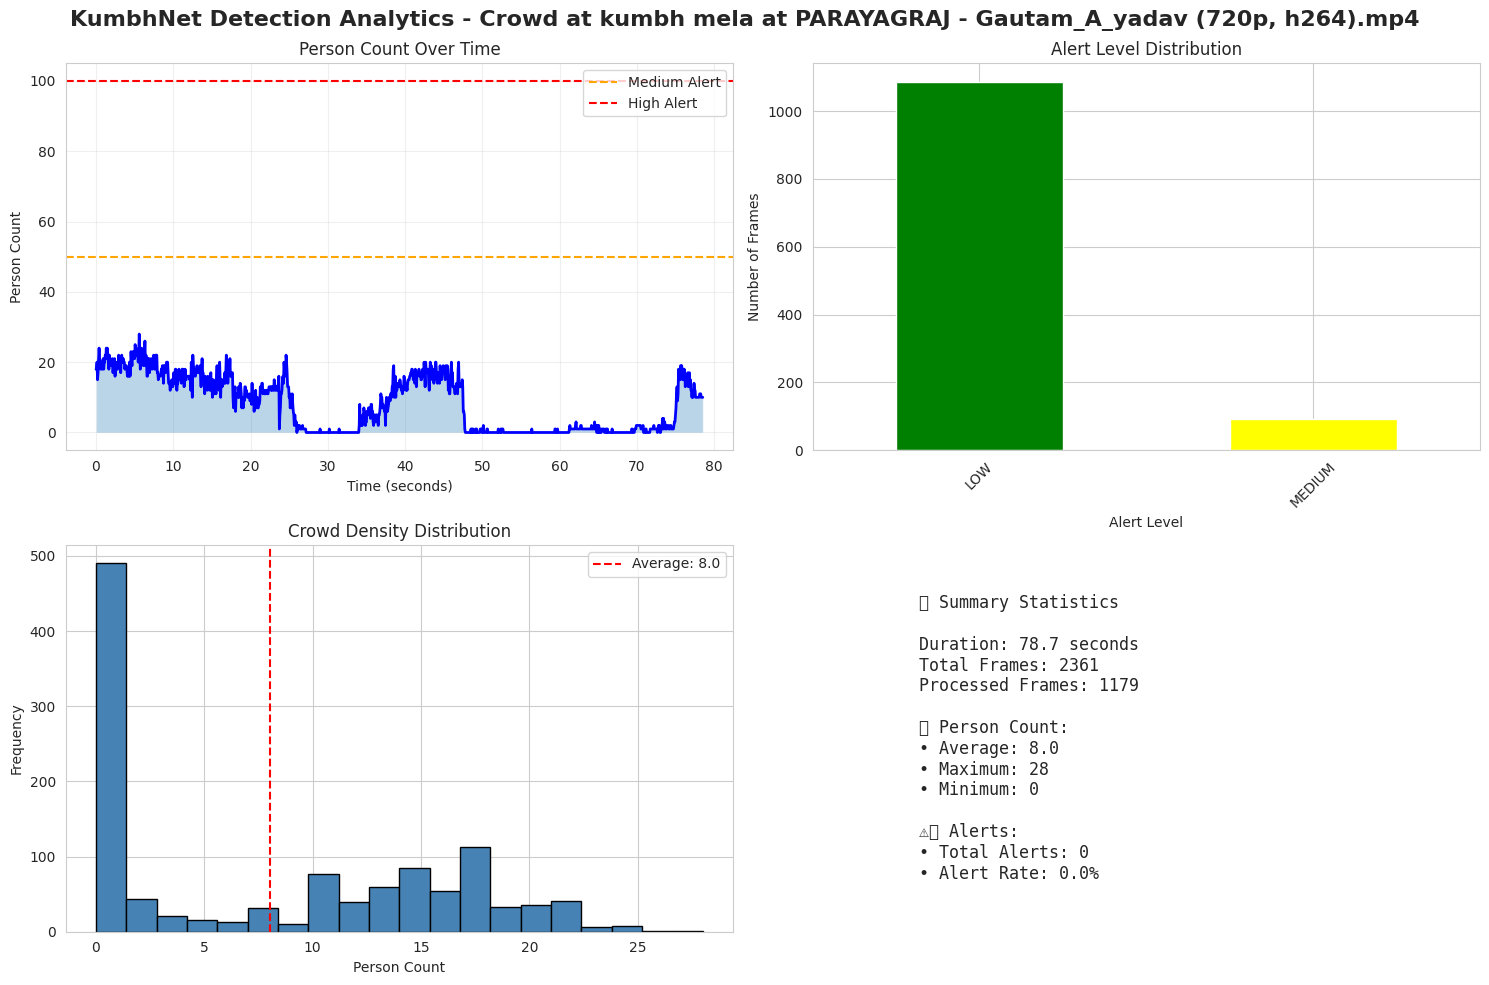


✓ All analytics generated!


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

def create_analytics(stats):
    """Create visualizations from detection statistics"""

    video_name = stats['video_name']
    df = pd.DataFrame(stats['frame_data'])

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'KumbhNet Detection Analytics - {video_name}',
                 fontsize=16, fontweight='bold')

    # 1. Person count timeline
    ax1 = axes[0, 0]
    ax1.plot(df['timestamp'], df['person_count'], linewidth=2, color='blue')
    ax1.fill_between(df['timestamp'], df['person_count'], alpha=0.3)
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Person Count')
    ax1.set_title('Person Count Over Time')
    ax1.grid(True, alpha=0.3)

    # Add threshold lines
    ax1.axhline(y=config['alerts']['medium'], color='orange',
                linestyle='--', label='Medium Alert')
    ax1.axhline(y=config['alerts']['high'], color='red',
                linestyle='--', label='High Alert')
    ax1.legend()

    # 2. Alert level distribution
    ax2 = axes[0, 1]
    alert_counts = df['alert_level'].value_counts()
    colors = {'LOW': 'green', 'MEDIUM': 'yellow', 'HIGH': 'orange', 'CRITICAL': 'red'}
    alert_counts.plot(kind='bar', ax=ax2, color=[colors.get(x, 'gray') for x in alert_counts.index])
    ax2.set_xlabel('Alert Level')
    ax2.set_ylabel('Number of Frames')
    ax2.set_title('Alert Level Distribution')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

    # 3. Density histogram
    ax3 = axes[1, 0]
    ax3.hist(df['person_count'], bins=20, color='steelblue', edgecolor='black')
    ax3.set_xlabel('Person Count')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Crowd Density Distribution')
    ax3.axvline(x=df['person_count'].mean(), color='red',
                linestyle='--', label=f'Average: {df["person_count"].mean():.1f}')
    ax3.legend()

    # 4. Statistics summary
    ax4 = axes[1, 1]
    ax4.axis('off')

    summary_text = f"""
    📊 Summary Statistics

    Duration: {stats['duration_seconds']:.1f} seconds
    Total Frames: {stats['total_frames']}
    Processed Frames: {stats['processed_frames']}

    👥 Person Count:
    • Average: {stats['avg_person_count']:.1f}
    • Maximum: {stats['max_person_count']}
    • Minimum: {stats['min_person_count']}

    ⚠️ Alerts:
    • Total Alerts: {stats['total_alerts']}
    • Alert Rate: {(stats['total_alerts']/stats['processed_frames']*100):.1f}%
    """

    ax4.text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
             verticalalignment='center')

    plt.tight_layout()

    # Save figure
    output_path = f"outputs/analytics/{video_name.replace('.mp4', '_analytics.png')}"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"✓ Analytics saved: {output_path}")

    plt.show()

# Generate analytics for all processed videos
print("Generating analytics...\n")

for stats in all_statistics:
    create_analytics(stats)

print("\n✓ All analytics generated!")

In [20]:
from google.colab import files
import shutil

print("Packaging results for download...\n")

# Create zip file with all outputs
shutil.make_archive('sanrakshak_outputs', 'zip', 'outputs')
shutil.make_archive('sanrakshak_processed_videos', 'zip', 'data/videos/processed')

print("✓ Files packaged!")
print("\nDownloading...\n")

# Download outputs
files.download('sanrakshak_outputs.zip')
files.download('sanrakshak_processed_videos.zip')

print("✓ Downloads complete!")
print("\nExtract these ZIP files on your computer to see:")
print("  • Annotated videos with detection boxes")
print("  • Statistics and analytics graphs")
print("  • Alert logs")

Packaging results for download...

✓ Files packaged!

Downloading...



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloads complete!

Extract these ZIP files on your computer to see:
  • Annotated videos with detection boxes
  • Statistics and analytics graphs
  • Alert logs


Sample detection frame:


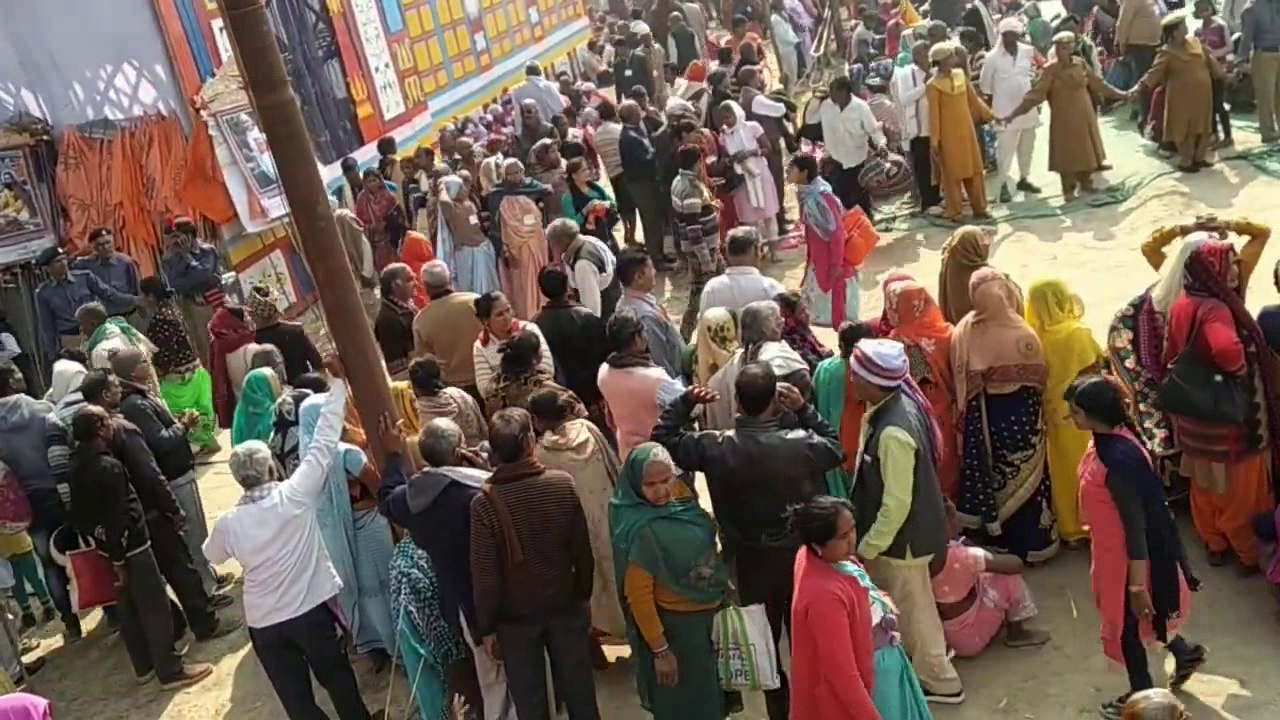

In [22]:
from IPython.display import Image, display
import cv2
import os

# Get first processed video
output_dir = "data/videos/processed"
videos = [f for f in os.listdir(output_dir) if f.endswith('.mp4')]

if videos:
    video_path = os.path.join(output_dir, videos[0])

    # Extract a sample frame
    cap = cv2.VideoCapture(video_path)

    # Get frame from middle of video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames // 2)

    ret, frame = cap.read()
    cap.release()

    if ret:
        # Save frame
        sample_path = "sample_detection.jpg"
        cv2.imwrite(sample_path, frame)

        print("Sample detection frame:")
        display(Image(filename=sample_path))
    else:
        print("Could not extract frame")
else:
    print("No processed videos found")